In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#IMPORTING LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

#READING THE DATASETS

In [5]:
train_path= "/content/drive/MyDrive/Datasets/Genre Classification Dataset/train_data.txt"
train_data = pd.read_csv(train_path, sep=":::", names=["TITLE", "GENRE", "DESCRIPTION"], engine="python")


In [6]:
train_data.head()

,TITLE,GENRE,DESCRIPTION
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [7]:
test_path='/content/drive/MyDrive/Datasets/Genre Classification Dataset/test_data.txt'
test_data=pd.read_csv( test_path , sep=':::',engine='python',names=['ID', 'Title','Description'])
test_data.head()

,ID,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


#DATA CLEANING


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54214 non-null  object
 1   GENRE        54214 non-null  object
 2   DESCRIPTION  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [9]:
train_data.isnull().sum() #To find missing values

TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

No missing values in the data

In [10]:
train_data.duplicated().sum() #To find duplicate values

0

No duplicate values in the train data

In [11]:

def cleantext(text):
    text = re.sub("'\''","",text)

    text = re.sub("[^a-zA-Z]"," ",text)

    # removing the whitespaces

    text = ' '.join(text.split())

    # convert text to lowercase

    text = text.lower()

    return text



train_data['DESCRIPTION'] = train_data['DESCRIPTION'].apply(lambda x:cleantext(x))
train_data['DESCRIPTION'].iloc[1]

'a brother and sister with a past incestuous relationship have a current murderous relationship he murders the women who reject him and she murders the women who get too close to him'

#DATA PREPROCESSING

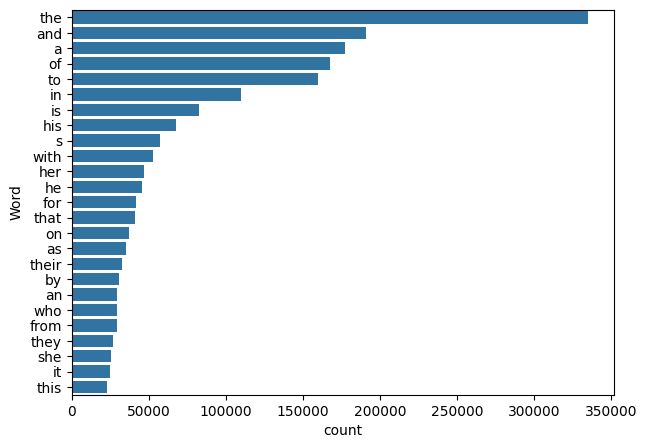

In [12]:
def showmostfrequentwords(text,no_of_words):

    allwords = ' '.join([char for char in text])
    allwords = allwords.split()
    fdist = nltk.FreqDist(allwords)

    wordsdf = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())})

    df = wordsdf.nlargest(columns="count",n = no_of_words)

    plt.figure(figsize=(7,5))
    ax = sns.barplot(data=df,x = 'count',y = 'word')
    ax.set(ylabel = 'Word')
    plt.show()

    return wordsdf


# 25 most frequent words

wordsdf = showmostfrequentwords(train_data['DESCRIPTION'],25)

In [13]:
wordsdf.sort_values('count',ascending=False).head(10).style.background_gradient(cmap = 'plasma')

,word,count
17,the,335159
8,and,191172
3,a,177196
57,of,167636
2,to,159412
1,in,109962
145,is,82628
6,his,67766
129,s,56990
69,with,52672


In [14]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# removing the stopwords

def removestopwords(text):

    removedstopword = [word for word in text.split() if word not in stop_words]
    return ' '.join(removedstopword)

train_data['DESCRIPTION'] = train_data['DESCRIPTION'].apply(lambda x:removestopwords(x))
train_data['DESCRIPTION'].iloc[1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'brother sister past incestuous relationship current murderous relationship murders women reject murders women get close'

In [15]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemma=WordNetLemmatizer()

def lematizing(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = lemma.lemmatize(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


train_data['DESCRIPTION'] = train_data['DESCRIPTION'].apply(lambda x: lematizing(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# Approach

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemming(sentence):

    stemmed_sentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemmed_sentence+=stem
        stemmed_sentence+=" "

    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

train_data['DESCRIPTION'] = train_data['DESCRIPTION'].apply(lambda text:stemming(text))
train_data['DESCRIPTION'].iloc[1]

'brother sister past incestu relationship current murder relationship murder woman reject murder woman get close'

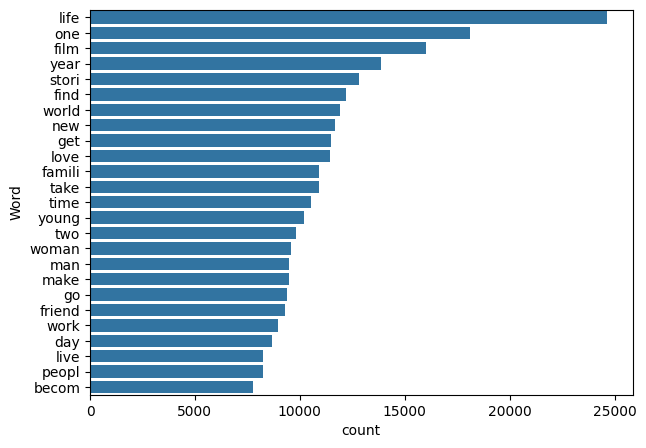

In [17]:
# visualising frewords

freq_df = showmostfrequentwords(train_data['DESCRIPTION'],25)

In [18]:
freq_df.sort_values('count',ascending=False).head(10).style.background_gradient(cmap = 'plasma')

,word,count
37,life,24627
82,one,18118
76,film,16013
4,year,13865
565,stori,12814
91,find,12208
418,world,11923
136,new,11670
59,get,11506
38,love,11458


In [19]:
movies_list = list(train_data['GENRE'].unique())
encode = [i for i in range(len(movies_list))]
mapper = dict(zip(movies_list,encode))
print(mapper)

{' drama ': 0, ' thriller ': 1, ' adult ': 2, ' documentary ': 3, ' comedy ': 4, ' crime ': 5, ' reality-tv ': 6, ' horror ': 7, ' sport ': 8, ' animation ': 9, ' action ': 10, ' fantasy ': 11, ' short ': 12, ' sci-fi ': 13, ' music ': 14, ' adventure ': 15, ' talk-show ': 16, ' western ': 17, ' family ': 18, ' mystery ': 19, ' history ': 20, ' news ': 21, ' biography ': 22, ' romance ': 23, ' game-show ': 24, ' musical ': 25, ' war ': 26}


In [20]:
train_data['GENRE'] = train_data['GENRE'].map(mapper)
train_data['GENRE'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

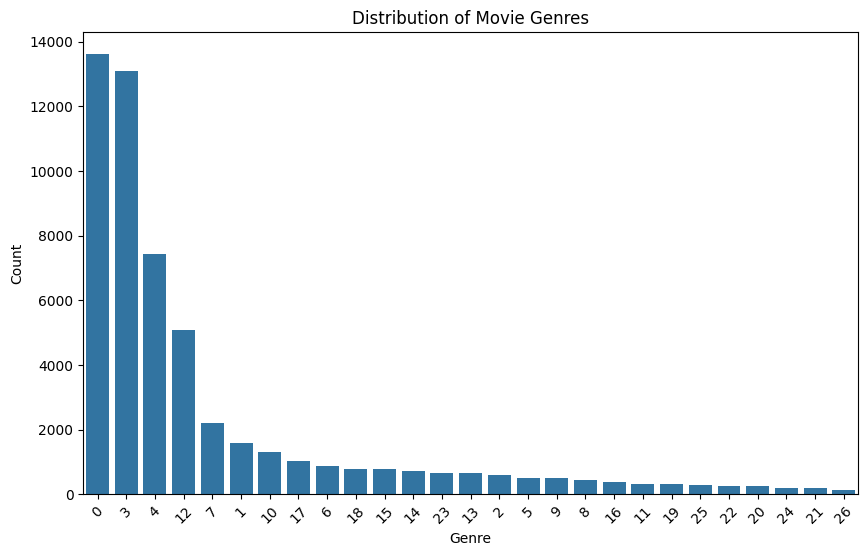

Class Counts:
GENRE
0     13613
3     13096
4      7447
12     5073
7      2204
1      1591
10     1315
17     1032
6       884
18      784
15      775
14      731
23      672
13      647
2       590
5       505
9       498
8       432
16      391
11      323
19      319
25      277
22      265
20      243
24      194
21      181
26      132
Name: count, dtype: int64


In [21]:
#Checking for class imbalance

class_counts = train_data['GENRE'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='GENRE', order=class_counts.index)
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Display class counts
print("Class Counts:")
print(class_counts)

#MODEL TRAINING

Part 1 Model Building

 + Using Countvectorizer

In [22]:
## count vectorizer

count_vec = CountVectorizer(max_df=0.90,min_df=2,
                           max_features=1000,stop_words='english')

bagofword_vec = count_vec.fit_transform(train_data['DESCRIPTION'])
bagofword_vec

<54214x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 1354240 stored elements in Compressed Sparse Row format>

In [23]:
test =train_data['GENRE']
X_train, X_test, y_train, y_test = train_test_split(bagofword_vec,test,
                                                    test_size=0.2)
X_train.shape,X_test.shape

((43371, 1000), (10843, 1000))

**NAIVE BAYES**

In [24]:
mb = MultinomialNB()
mb.fit(X_train,y_train)
mbpred = mb.predict(X_test)
print(accuracy_score(y_test,mbpred))

0.48187770912109196


**LOGISTIC REGRESSION**

In [25]:
l=LogisticRegression()
l.fit(X_train,y_train)
l_pred=l.predict(X_test)
print(accuracy_score(y_test,l_pred))

0.5353684404685051


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Part 2 Model Building

 + Changing from Countvectorizer to TFDIF vectorizer

In [26]:
#Labeling each 'genre' with an unique number

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(train_data['GENRE'])

X_train,X_test,y_train,y_test = train_test_split(train_data['DESCRIPTION']
                                                ,y,test_size=0.2,
                                                random_state=557)

X_train.shape,X_test.shape

((43371,), (10843,))

In [27]:
#Performing tf-idf

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain_tfidf = tfidf_vectorizer.fit_transform(X_train.values.astype('U'))
xtest_tfidf = tfidf_vectorizer.transform(X_test.values.astype('U'))

**NAIVE-BAYES**

In [28]:
mb = MultinomialNB()
mb.fit(xtrain_tfidf,y_train)
mbpred = mb.predict(xtest_tfidf)
print(accuracy_score(y_test,mbpred))

0.502167296873559


**LOGISTIC REGRESSION**

In [30]:
l=LogisticRegression()
l.fit(xtrain_tfidf,y_train)
l_pred=l.predict(xtest_tfidf)
print(accuracy_score(y_test,l_pred))

0.5861846352485475


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#TESTING OF THE MODEL

**PREPROCESSING OF TEST DATASET**

In [33]:
def test(text,model):

    text = cleantext(text)
    text = removestopwords(text)
    text = lematizing(text)
    text = stemming(text)

    text_vector = tfidf_vectorizer.transform([text])
    predicted = model.predict(text_vector)
    return predicted



ans = test_data['Description'].apply(lambda text:test(text,mb))

# printing the
# print(list(mapper.keys())[list(mapper.values()).index(ans)])

ans

0        [0]
1        [0]
2        [3]
3        [0]
4        [0]
        ... 
54195    [0]
54196    [0]
54197    [4]
54198    [3]
54199    [3]
Name: Description, Length: 54200, dtype: object

In [34]:
predicted_genres = []
for i in range(len(ans)):

    index_val = ans[i][0]
    predicted_genres.append(list(mapper.keys())[list(mapper.values()).index(index_val)])
mapper

{' drama ': 0,
 ' thriller ': 1,
 ' adult ': 2,
 ' documentary ': 3,
 ' comedy ': 4,
 ' crime ': 5,
 ' reality-tv ': 6,
 ' horror ': 7,
 ' sport ': 8,
 ' animation ': 9,
 ' action ': 10,
 ' fantasy ': 11,
 ' short ': 12,
 ' sci-fi ': 13,
 ' music ': 14,
 ' adventure ': 15,
 ' talk-show ': 16,
 ' western ': 17,
 ' family ': 18,
 ' mystery ': 19,
 ' history ': 20,
 ' news ': 21,
 ' biography ': 22,
 ' romance ': 23,
 ' game-show ': 24,
 ' musical ': 25,
 ' war ': 26}

In [35]:
## mapping the training genre as well

newmap = dict([(value,key) for key,value in mapper.items()])
newmap

{0: ' drama ',
 1: ' thriller ',
 2: ' adult ',
 3: ' documentary ',
 4: ' comedy ',
 5: ' crime ',
 6: ' reality-tv ',
 7: ' horror ',
 8: ' sport ',
 9: ' animation ',
 10: ' action ',
 11: ' fantasy ',
 12: ' short ',
 13: ' sci-fi ',
 14: ' music ',
 15: ' adventure ',
 16: ' talk-show ',
 17: ' western ',
 18: ' family ',
 19: ' mystery ',
 20: ' history ',
 21: ' news ',
 22: ' biography ',
 23: ' romance ',
 24: ' game-show ',
 25: ' musical ',
 26: ' war '}

In [36]:
print(newmap)

{0: ' drama ', 1: ' thriller ', 2: ' adult ', 3: ' documentary ', 4: ' comedy ', 5: ' crime ', 6: ' reality-tv ', 7: ' horror ', 8: ' sport ', 9: ' animation ', 10: ' action ', 11: ' fantasy ', 12: ' short ', 13: ' sci-fi ', 14: ' music ', 15: ' adventure ', 16: ' talk-show ', 17: ' western ', 18: ' family ', 19: ' mystery ', 20: ' history ', 21: ' news ', 22: ' biography ', 23: ' romance ', 24: ' game-show ', 25: ' musical ', 26: ' war '}


In [37]:
test_path_sol='/content/drive/MyDrive/Datasets/Genre Classification Dataset/test_data_solution.txt'
test_sol=pd.read_csv( test_path_sol , sep=':::',engine='python',names=['ID', 'Title','Genre','Description'])
test_sol.head()

,ID,Title,Genre,Description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


In [39]:

test_data['Predicted Genre'] = np.array(predicted_genres)
test_sol['Predicted Genre']=test_data['Predicted Genre']


In [40]:
test_sol = test_sol[['ID','Title','Genre','Predicted Genre']]
test_sol

,ID,Title,Genre,Predicted Genre
0,1,Edgar's Lunch (1998),thriller,drama
1,2,La guerra de papá (1977),comedy,drama
2,3,Off the Beaten Track (2010),documentary,documentary
3,4,Meu Amigo Hindu (2015),drama,drama
4,5,Er nu zhai (1955),drama,drama
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",horror,drama
54196,54197,Der letzte Mohikaner (1965),western,drama
54197,54198,Oliver Twink (2007),adult,comedy
54198,54199,Slipstream (1973),drama,documentary
